In [14]:
# Last mod: FA Oct 11 - first version

# Predicting ages from spectroscopic abundances with XGBoost 

First, let's import some libraries:

In [1]:
import numpy as np #numpy
import pandas as pd
import matplotlib.pyplot as plt  #matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table  #astropy
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde  #scipy: science python
import seaborn as sns  #seaborn: data visualization
import os.path

from time import time
from sklearn import manifold, datasets

import umap  #UMAP
from sklearn.decomposition import PCA  #PCA
from sklearn.manifold import TSNE  #t-SNE
from itertools import product

## Read asteroseismic age data tables

As an anchor for our method, we want asteroseismic ages for red giant stars. 
The most reliable ones are using Kepler + APOGEE data ([Miglio+2021](https://www.aanda.org/articles/aa/full_html/2021/01/aa38307-20/aa38307-20.html)):

In [2]:
#TAULA QUE HARUEM DE ESTUDIAR
miglio2021 = Table.read("../data/kepler_apogee_miglio2021.fit")
miglio2021 = miglio2021.to_pandas()
print(miglio2021.columns)
miglio2021.head()

Index(['APOGEE', 'KIC', 'Jmag', 'Hmag', 'Ksmag', 'RAdeg', 'DEdeg', '__Fe_H_',
       '__alpha_M_', 'Age', 'b_Age', 'b_age_lc', 'Mass', 'b_Mass', 'b_mass_lc',
       'Rad', 'b_Rad', 'b_rad_lc', 'Dist', 'b_Dist', 'b_dist_lc', 'Av', 'b_Av',
       'b_av_lc', 'evstate', 'zmax', 'e_zmax', 'Ecc', 'e_Ecc', 'Rperi',
       'e_Rperi', 'Rap', 'e_Rap', 'GalR', 'Galphi', 'GalZ', 'vR', 'vT', 'vZ',
       '_RA', '_DE'],
      dtype='object')


,APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,__Fe_H_,__alpha_M_,Age,...,Rap,e_Rap,GalR,Galphi,GalZ,vR,vT,vZ,_RA,_DE
0,b'2M19222920+3710285 ',1569842,9.589,9.074,8.989,290.6217,37.1746,-0.24,0.12,9.8,...,8.328,0.005,7.933,0.072,0.131,-29.82,209.19,21.51,290.62167,37.17458
1,b'2M19300513+3717470 ',1726291,11.206,10.679,10.547,292.5214,37.2964,-0.34,0.19,10.1,...,10.420,0.012,7.812,0.140,0.204,31.83,245.94,10.69,292.52137,37.29639
2,b'2M19045380+3741230 ',2283721,11.266,10.709,10.590,286.2242,37.6897,-0.19,0.11,9.4,...,7.798,0.010,7.680,0.198,0.415,-16.38,210.65,-16.16,286.22417,37.68972
3,b'2M19060736+3740100 ',2284679,9.923,9.456,9.335,286.5307,37.6694,-0.45,0.21,11.2,...,8.204,0.004,7.934,0.067,0.157,66.53,37.45,-39.19,286.53067,37.66944
4,b'2M19280882+3736381 ',2305590,9.829,9.235,9.128,292.0368,37.6106,-0.30,0.24,10.2,...,9.188,0.026,7.835,0.128,0.197,111.85,114.69,27.80,292.03675,37.61058


We also have the K2 + GALAH data from [Zinn+2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..251...23Z/abstract):

In [17]:
zinn2020 = Table.read("../data/k2_galah_zinn2020.fits")
zinn2020 = zinn2020.to_pandas()
zinn2020

,EPIC,GALAH,age,e_age,FeH,Teff,MgFe,e_FeH,e_Teff,e_MgFe
0,220387110,161007003801220,7.7,1.80,-0.180,4691,0.150,0.063,91,0.058
1,220352927,161007003801158,11.0,1.50,-1.300,4883,0.120,0.110,124,0.120
2,220420379,161007003801285,5.2,2.90,-0.600,4705,0.320,0.120,136,0.180
3,220329169,161007003801110,4.1,0.74,-0.300,4864,0.120,0.066,95,0.064
4,220425435,161007003801301,9.2,2.70,-1.600,5060,0.110,0.200,174,0.180
...,...,...,...,...,...,...,...,...,...,...
1342,246041623,161105003601035,4.9,0.89,0.018,4540,0.068,0.048,75,0.036
1343,246213656,170723004601073,5.6,2.20,-0.540,4751,0.370,0.100,128,0.140
1344,246292186,161106002101331,8.1,2.60,-0.450,4886,0.200,0.083,113,0.100
1345,246212890,161106002101068,8.5,2.50,-0.340,4532,0.190,0.064,86,0.061


The TESS CVZ analysis of [Mackereth+2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.1947M/abstract):

In [18]:
mackereth2021 = Table.read("../data/tess_cvz_mackereth2021.fits")
mackereth2021 = mackereth2021.to_pandas()
for i in mackereth2021:
    print(i)
mackereth2021.head()

source_id
TIC
N_sectors
ra
ra_error
dec
dec_error
l
b
ecl_lon
ecl_lat
parallax
parallax_error
pmra
pmra_error
pmdec
pmdec_error
radial_velocity
radial_velocity_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
hmag
jmag
kmag
phot_g_mean_mag
phot_bp_mean_mag
phot_rp_mean_mag
A_K
numax_COR
numax_err_COR
dnu_COR
dnu_err_COR
numax_BHM
numax_err_BHM
dnu_BHM
dnu_err_BHM
numax_A2Z
numax_err_A2Z
dnu_A2Z
dnu_err_A2Z
mean_numax
mean_numax_err
mean_dnu
mean_dnu_err
N_pipelines_mean
seismic_param_gold
logg_HERMES
e_logg_HERMES
Teff_SKYMAPPER
e_Teff_SKYMAPPER
feh_SKYMAPPER
e_feh_SKYMAPPER
ecc_MB2018
ecc_err_MB2018
rperi_MB2018
rperi_err_MB2018
rap_MB2018
rap_err_MB2018
zmax_MB2018
zmax_err_MB2018
APOGEE_ID_APOGEE
FE_H_APOGEE
FE_H_ERR_APOGEE
MG_FE_APOGEE
MG_FE_ERR_APOGEE
LOGG_APOGEE
LOGG_ERR_APOGEE
TEFF_APOGEE
TEFF_ERR_APOGEE
age_PARAM_BHM
age_68L_PARAM_BHM
age_68U_PARAM_BHM
mass_PARAM_B

,source_id,TIC,N_sectors,ra,ra_error,dec,dec_error,l,b,ecl_lon,...,luminosity_68L_APO_GAIA,luminosity_68U_APO_GAIA,evstate_MV,evstate_agreement_MV,lum_flag_BHM,lum_flag_COR,lum_flag_A2Z,numax_dnu_consistent,numax_predicted,numax_predicted_err
0,4759266867156545536,149346975,12,83.608318,0.016513,-61.367357,0.020950,270.394887,-32.740472,58.713340,...,-9999.0,-9999.0,-1,0,0,0,0,0,7.244006,0.665653
1,4757766995858979840,149302331,12,83.385476,0.016820,-61.319953,0.019911,270.344647,-32.849485,57.983093,...,-9999.0,-9999.0,-1,0,1,1,0,0,24.013386,1.874717
2,4759263813434301824,149347992,13,83.739239,0.019474,-61.176164,0.023587,270.164558,-32.686084,60.037145,...,-9999.0,-9999.0,0,0,0,0,0,0,59.815414,4.248561
3,4759470762138173056,149253409,12,82.866857,0.031719,-60.880627,0.031476,269.836790,-33.122163,57.681476,...,-9999.0,-9999.0,0,0,0,0,0,0,407.290462,27.727427
4,4759428911976861056,149391651,12,84.190435,0.020184,-60.230225,0.023538,269.033676,-32.497111,65.029296,...,-9999.0,-9999.0,0,0,0,0,0,0,33.074804,3.034497


The CoRoT + APOGEE data from [Anders+2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A..30A/abstract):

In [19]:
anders2017 = Table.read("../data/corot_apogee_anders2017.fit")
anders2017 = anders2017.to_pandas()
for i in anders2017:
    print(i)
anders2017.head()

CoRoT
APOGEE
RAJ2000
DEJ2000
GLON
GLAT
FIELD
run
Seismic
numax
e_numax
Dnu
e_Dnu
evstat
ASPCAP
File
Tel
Loc
TargFlags
NVisits
SNR
StarFlags
__RV_
sigma
e__RV_
Teff
e_Teff
logg
e_logg
__M_H_
__M_H_A
e__M_H_
__alpha_M_
e__alpha_M_
chi2
ASPCAPFlags
__Al_H_
__Ca_H_
__C_H_
__Fe_H_
__K_H_
__Mg_H_
__Mn_H_
__Na_H_
__Ni_H_
__N_H_
__O_H_
__Si_H_
__S_H_
__Ti_H_
__V_H_
e__Al_H_
e__Ca_H_
e__C_H_
e__Fe_H_
e__K_H_
e__Mg_H_
e__Mn_H_
e__Na_H_
e__Ni_H_
e__N_H_
e__O_H_
e__Si_H_
e__S_H_
e__Ti_H_
e__V_H_
f__Al_H_
f__Ca_H_
f__C_H_
f__Fe_H_
f__K_H_
f__Mg_H_
f__Mn_H_
f__Na_H_
f__Ni_H_
f__N_H_
f__O_H_
f__Si_H_
f__S_H_
f__Ti_H_
f__V_H_
EKs
MetEKs
SFDE_B-V_
RCDist
Visits
BmagO
e_BmagO
VmagO
e_VmagO
RmagO
e_RmagO
ImagO
e_ImagO
AllWISE
Jmag
e_Jmag
Hmag
e_Hmag
Ksmag
e_Ksmag
W1mag
e_W1mag
W2mag
e_W2mag
W3mag
e_W3mag
W4mag
e_W4mag
BmagA
e_BmagA
VmagA
e_VmagA
gmagA
e_gmagA
rmagA
e_rmagA
imagA
e_imagA
RAEdeg
DEEdeg
CCD
WIN
x
y
SpType
LC
Tcol
PPMXL
USNOB1
_2MASS
USNOA2
CMC14
TYCHO2
UCAC2
UCAC4
pmRA
e_pmRA
pmDE
e_pmDE
UC

,CoRoT,APOGEE,RAJ2000,DEJ2000,GLON,GLAT,FIELD,run,Seismic,numax,...,e_vYg,vZg,e_vZg,vRg,e_vRg,vPhig,e_vPhig,Rguide,e_Rguide,Simbad
0,100448189,b'2M19223319+0141341',290.638327,1.692813,38.00855,-6.13865,b'COROTC ',b'LRc01',b'automatic fit ',16.93,...,24.80595,-27.840206,29.30032,-99.073242,24.37741,236.2751,19.74985,6.656875,0.570484,b'Simbad\r'
1,100483847,b'2M19224577+0131126',290.690732,1.520180,37.87887,-6.26485,b'COROTC ',b'LRc01',b'automatic fit ',40.47,...,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.00000,0.000000,0.000000,b'Simbad\r'
2,100528464,b'2M19230164+0138059',290.756852,1.634995,38.01203,-6.27044,b'COROTC ',b'LRc01',b'automatic fit ',15.02,...,19.68832,18.838099,24.60888,49.516911,19.52293,230.8939,15.66453,7.030789,0.485509,b'Simbad\r'
3,100556001,b'2M19231160+0135576',290.798358,1.599337,37.99950,-6.32371,b'COROTC ',b'LRc01',b'supervised fit',38.40,...,8.27355,-12.410370,9.80267,-5.566450,7.43160,216.8675,7.35867,7.209924,0.267462,b'Simbad\r'
4,100557143,b'2M19231202+0140227',290.800092,1.672996,38.06602,-6.29121,b'COROTC ',b'LRc01',b'automatic fit ',55.97,...,28.20678,64.429604,35.50668,95.727333,27.93862,227.3875,22.55723,6.479927,0.650302,b'Simbad\r'


Comentaris: 
- Puc observar que les taules miglio i anders es poden unir mitjançant la columna APOGEE
- Mackereth2021 te una columna que fica apogee_id, per lo que tambe es podria unir
- Zinn es la unica taula que crec que no podria unirla amb les demes

## 1st TASK
### Try to understand the content of the first 3 tables and do some basic plots:
        
* Teff - logg diagram
* [Mg/Fe] - [Fe/H] diagram
* age uncertainty as a function of age
* location in the Galaxy (RGal vs ZGal, XGal vs YGal...)

### TEFF - LOGG DIAGRAM

Text(0, 0.5, 'logg')

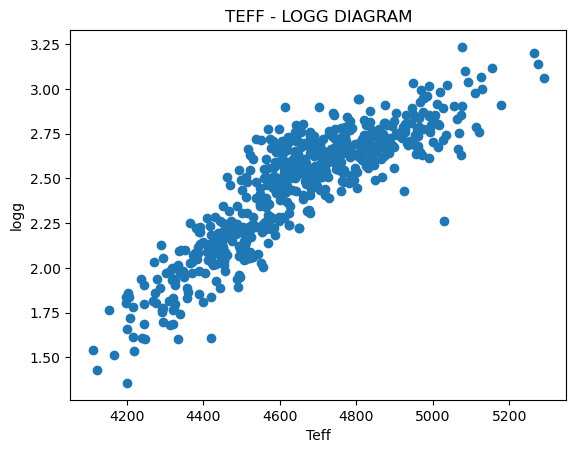

In [20]:
# Anders2017 (La usamos para comprovar reusltados)
x1 = anders2017['Teff']
y1 = anders2017['logg']
plt.scatter(x1,y1)
plt.title('TEFF - LOGG DIAGRAM')
plt.xlabel('Teff')
plt.ylabel('logg')

### [Mg/Fe] - [Fe/H] diagram

Text(0, 0.5, '[Fe/H]')

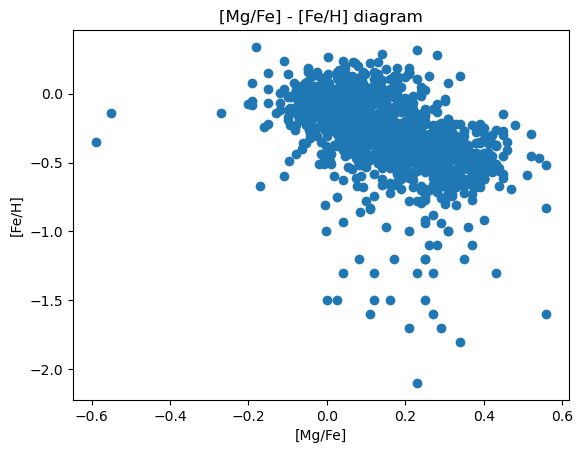

In [21]:
#Zinn
x1 = zinn2020['MgFe']
y1 = zinn2020['FeH']

plt.scatter(x1,y1)
plt.title('[Mg/Fe] - [Fe/H] diagram')
plt.xlabel('[Mg/Fe]')
plt.ylabel('[Fe/H]')

### age uncertainty as a function of age

Text(0, 0.5, 'e_age')

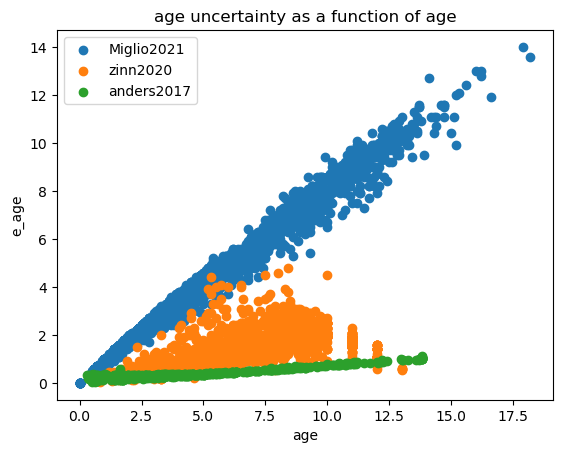

In [22]:
#Ages
x1 = miglio2021['Age']
y1 = miglio2021['b_Age']
x2 = zinn2020['age']
y2 = zinn2020['e_age']
#x3 = mackereth2021['age_PARAM_BHM']
#y3 = mackereth2021['age_68L_PARAM_BHM']
x4 = anders2017['AgeM']
y4 = anders2017['eAgeI']
plt.scatter(x1,y1)
plt.scatter(x2,y2)
#plt.scatter(x3,y3)
plt.scatter(x4,y4)
plt.title('age uncertainty as a function of age')
plt.legend(['Miglio2021', 'zinn2020', 'anders2017'])
plt.xlabel('age')
plt.ylabel('e_age')

### location in the Galaxy (RGal vs ZGal, XGal vs YGal...)

Text(0, 0.5, 'Z')

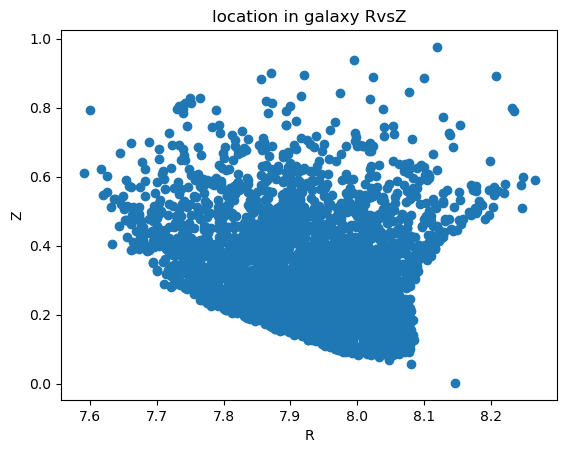

In [23]:
#Miglio2021
x1 = miglio2021['GalR']
y1 = miglio2021['GalZ']
plt.scatter(x1,y1)
plt.title('location in galaxy RvsZ')
plt.xlabel('R')
plt.ylabel('Z')

Text(0, 0.5, 'Y')

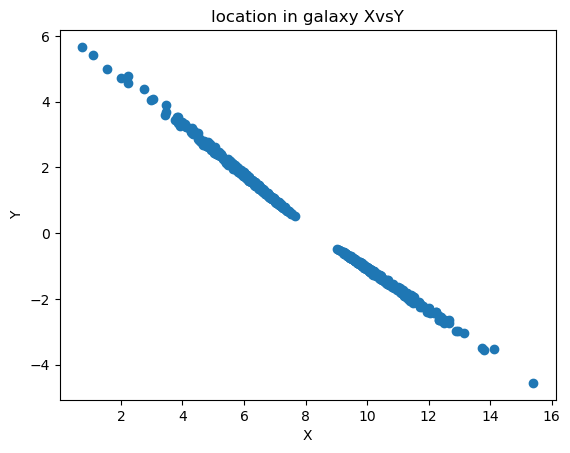

In [24]:
#anders2017
x1 = anders2017['Xg']
y1 = anders2017['Yg']
plt.scatter(x1,y1)
plt.title('location in galaxy XvsY')
plt.xlabel('X')
plt.ylabel('Y')

## Data of red-giant stars for which we want to predict ages

### APOGEE DR17

This file is BIG so it's not included in the data folder. Even the light version is 1.7 GB:
* Data model: https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html
* "Lite" file for download: https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits

The file needs to be cleaned so as to only select red-giant stars with good quality etc...

In [ ]:
miglio2021 = Table.read("https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits")
miglio2021 = miglio2021.to_pandas()
print(miglio2021.columns)

Ho filtrarem nomes per a red giants, fent que 2500<Teff<20000 i que 10^4 < L <10^6

### GALAH DR3

Also the GALAH files are big (and therefore not included in the data folder):

* Data directory: https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR3/
* Summary page: https://www.galah-survey.org/dr3/overview/

Also for this dataset we will have to select bona-fide red-giant stars. 